In [136]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import torch.optim as optim
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import MultiOutputMixin, RegressorMixin, BaseEstimator, _fit_context
from abc import ABCMeta, abstractmethod
from sklearn.utils.validation import check_is_fitted, _check_sample_weight
from sklearn.utils.extmath import safe_sparse_dot
from numbers import Integral

In [137]:
stock_price_df = pd.read_csv('./stock_price.csv', index_col=False)
stock_price_df['<Date>'] = pd.to_datetime(stock_price_df['<Date>'])
stock_price_df = stock_price_df.sort_values(by='<Date>', ascending=True).set_index('<Date>')
stock_price_df.head()

,<Ticker>,<Open>,<High>,<Low>,<Close>,<Volume>
<Date>,,,,,,
2014-01-24,BID,14.4241,14.8037,14.0446,14.2723,8417060
2014-01-27,BID,14.1964,14.2723,13.7409,13.9686,3240910
2014-02-06,BID,13.8168,13.8927,13.3613,13.3613,959590
2014-02-07,BID,13.2095,13.2854,12.5262,12.6021,2987600
2014-02-10,BID,12.5262,13.0576,12.2984,12.9058,4052090


In [138]:
stock_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1847 entries, 2014-01-24 to 2021-06-25
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <Ticker>  1847 non-null   object 
 1   <Open>    1847 non-null   float64
 2   <High>    1847 non-null   float64
 3   <Low>     1847 non-null   float64
 4   <Close>   1847 non-null   float64
 5   <Volume>  1847 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 101.0+ KB


In [139]:
stock_price_df.duplicated().sum()

0

In [140]:
stock_price_df.describe().T

,count,mean,std,min,25%,50%,75%,max
<Open>,1847.0,2.580522e+01,1.168290e+01,10.1164,15.24105,2.184560e+01,3.637285e+01,5.398760e+01
<High>,1847.0,2.620895e+01,1.187267e+01,10.1967,15.43810,2.227060e+01,3.703135e+01,5.487270e+01
<Low>,1847.0,2.544533e+01,1.150020e+01,10.0361,15.03770,2.162220e+01,3.569670e+01,5.290590e+01
<Close>,1847.0,2.582485e+01,1.167851e+01,10.1164,15.25500,2.193060e+01,3.644620e+01,5.457760e+01
<Volume>,1847.0,1.895362e+06,1.538950e+06,51430.0000,800655.00000,1.531780e+06,2.523570e+06,1.570104e+07


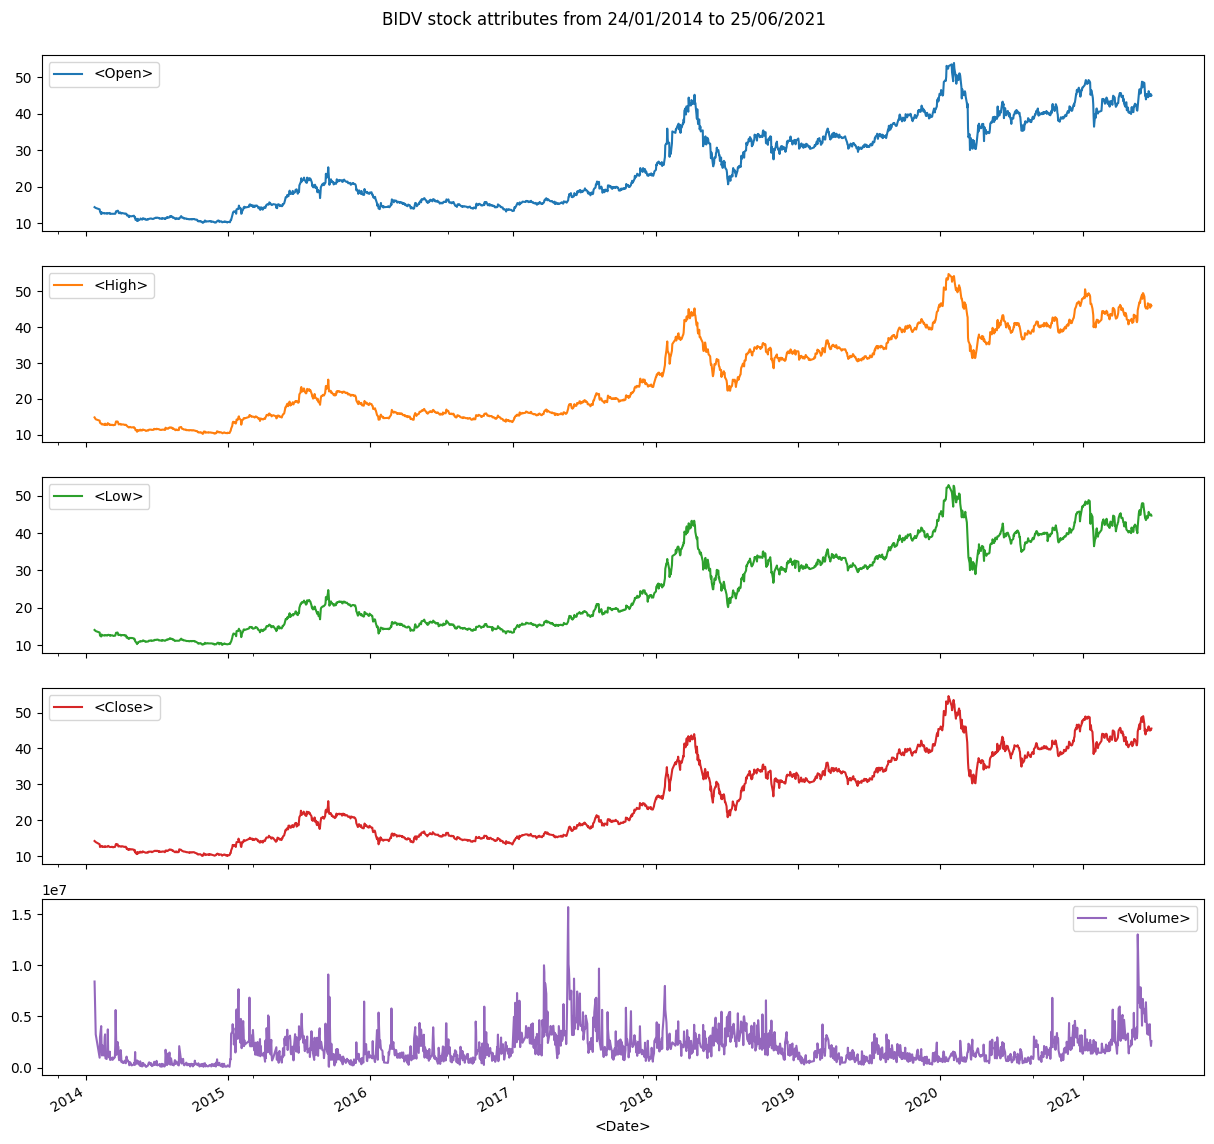

In [141]:
stock_price_df.plot(subplots=True, figsize=(15, 15))
plt.suptitle('BIDV stock attributes from 24/01/2014 to 25/06/2021', y=0.91)
plt.show()

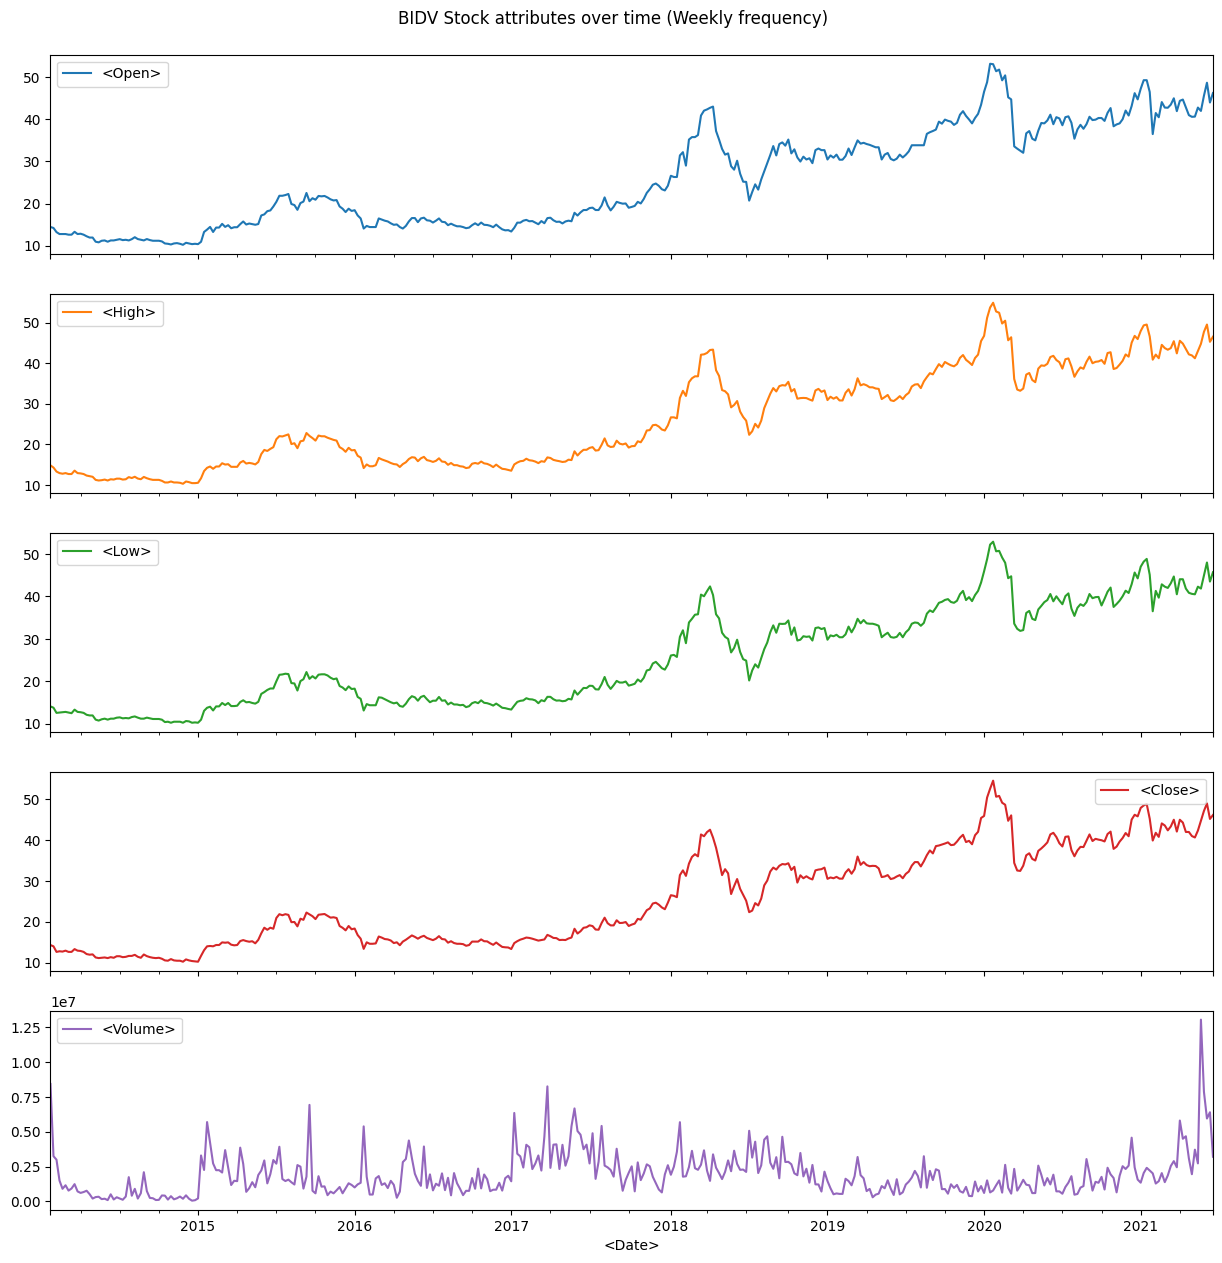

In [142]:
stock_price_df.asfreq('W', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('BIDV Stock attributes over time (Weekly frequency)', y=0.91)
plt.show()

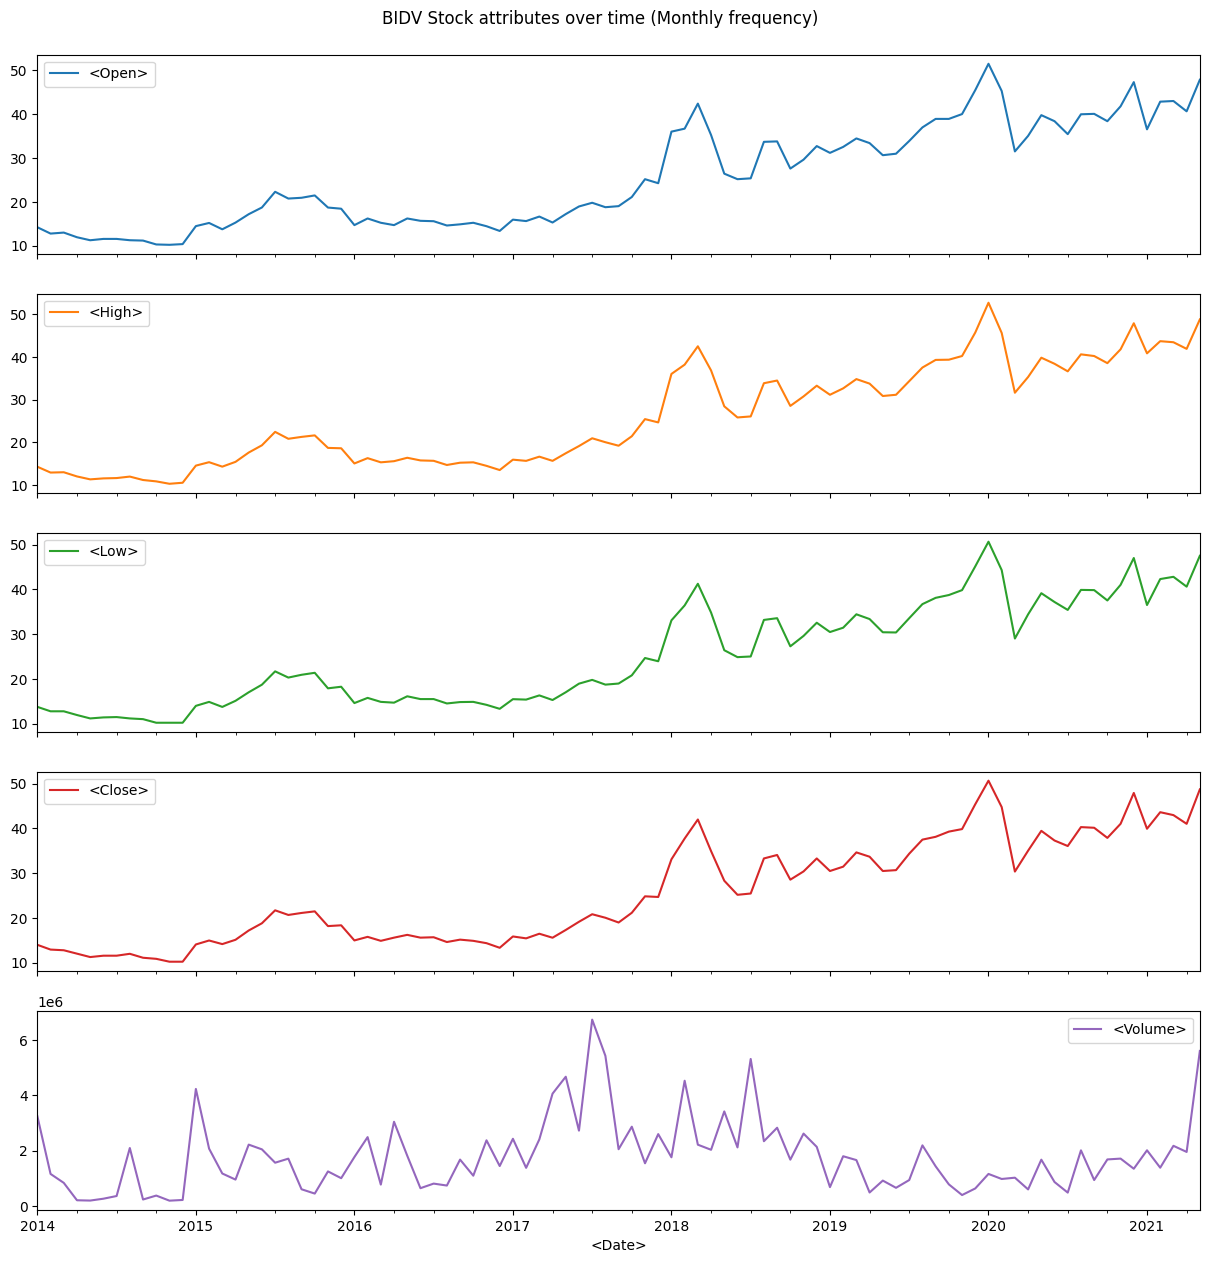

In [143]:
stock_price_df.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('BIDV Stock attributes over time (Monthly frequency)', y=0.91)
plt.show()

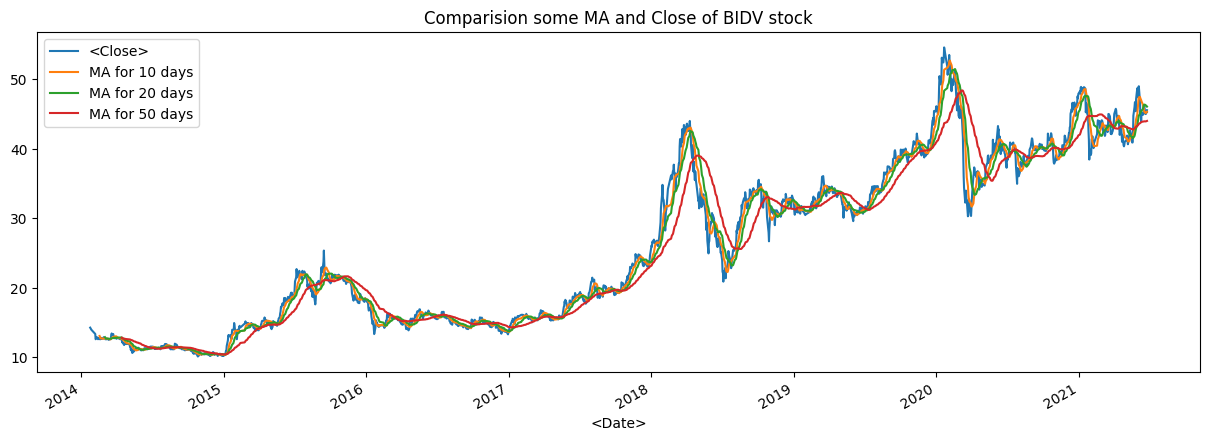

In [144]:
#computing moving average(ma)
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    stock_price_df[col_name] = stock_price_df['<Close>'].rolling(ma).mean()

stock_price_df[['<Close>', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some MA and Close of BIDV stock')
plt.show()

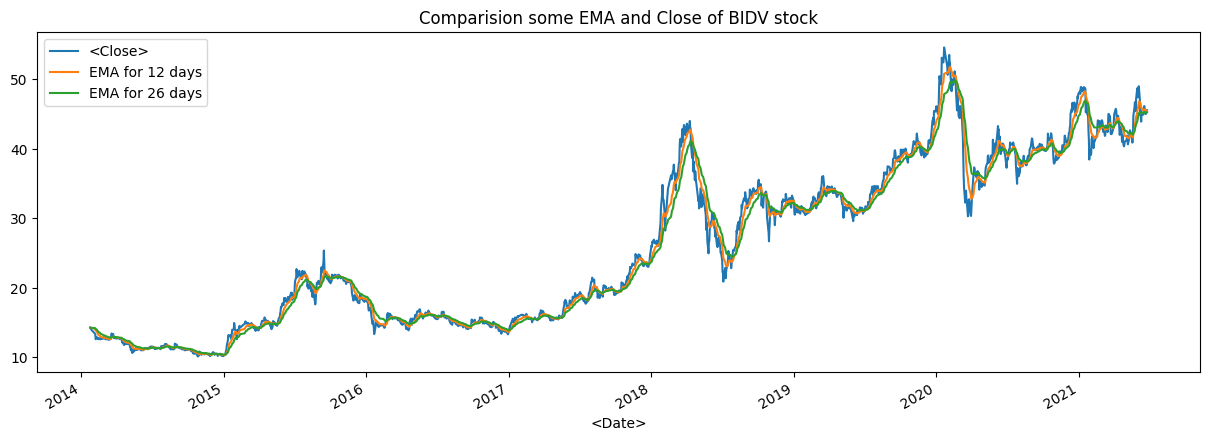

In [145]:
#computing exponential moving average (ema)
ema_day = [12, 26]

for ema in ema_day:
    col_name = f'EMA for {ema} days'
    stock_price_df[col_name] = stock_price_df['<Close>'].ewm(span=ema, adjust=False).mean()

stock_price_df[['<Close>', 'EMA for 12 days', 'EMA for 26 days']].plot(figsize=(15,5))
plt.title('Comparision some EMA and Close of BIDV stock')
plt.show()

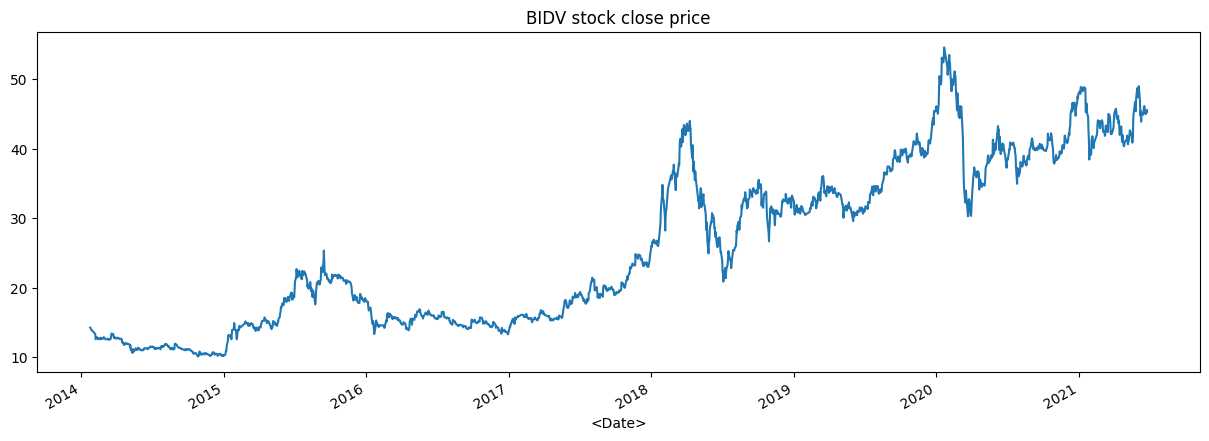

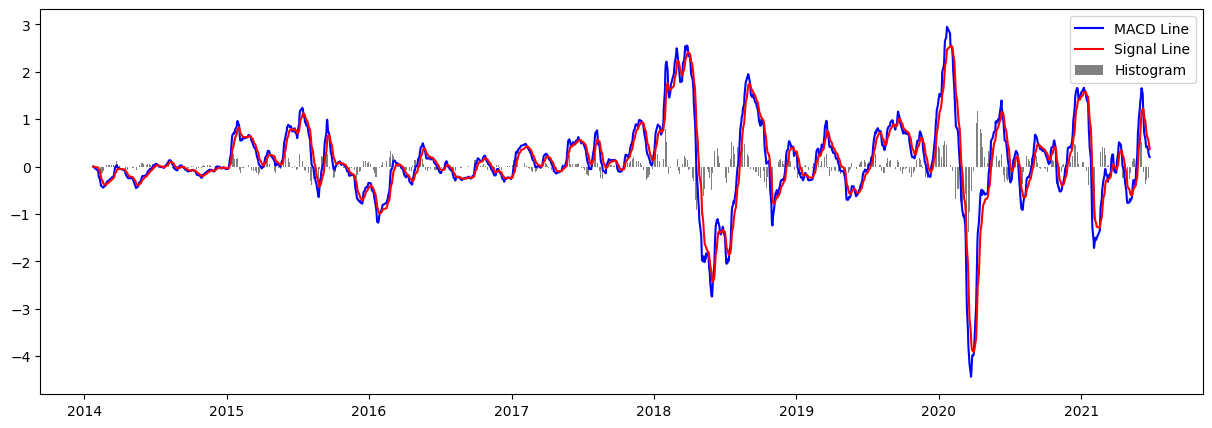

In [146]:
#computing Moving average convergence/divergence(MACD) & signal line

#Plotting Close Price
plt.figure(figsize=(15, 5))
stock_price_df['<Close>'].plot()
plt.title('BIDV stock close price')
plt.show()

#Plottinf MACD
plt.figure(figsize=(15, 5))
stock_price_df['MACD'] = stock_price_df['EMA for 12 days'] - stock_price_df['EMA for 26 days']
stock_price_df['Signal Line'] = stock_price_df['MACD'].ewm(span=9, adjust=False).mean()
stock_price_df['MACD_Diff'] = stock_price_df['MACD'] - stock_price_df['Signal Line']
plt.plot(stock_price_df['MACD'], label='MACD Line', color='blue')
plt.plot(stock_price_df['Signal Line'], label='Signal Line', color='red')
plt.bar(stock_price_df.index, stock_price_df['MACD_Diff'], label='Histogram', color='grey')
plt.legend()

plt.show()

C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\3100105023.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_price_df['Signal'][i] = 0
C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\3100105023.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_price_df['Signal'][i] = 0
C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\3100105023.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_price_df['Signal'][i] = 0
C

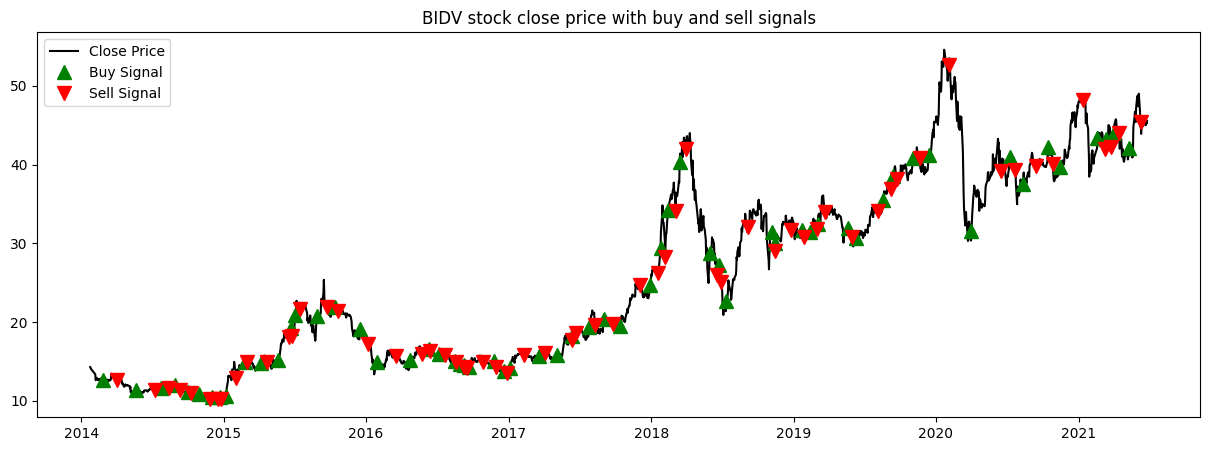

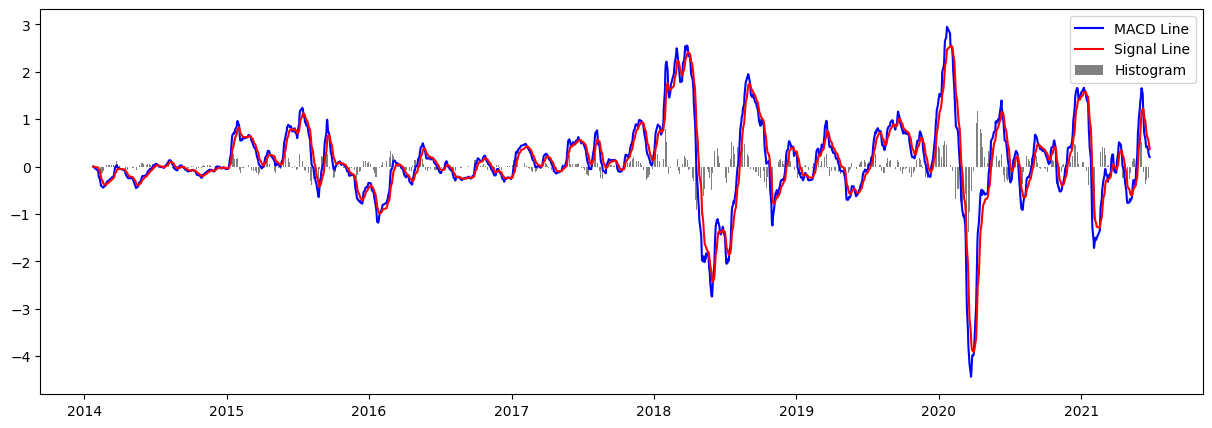

In [147]:
# Applying MACD strategy on close price
stock_price_df['Signal'] = 0
stock_price_df['Position'] = 0

for i in range(1, len(stock_price_df)):
    if stock_price_df['MACD'][i] > stock_price_df['Signal Line'][i]:
        stock_price_df['Signal'][i] = 1
    else:
        stock_price_df['Signal'][i] = 0

stock_price_df['Position'] = stock_price_df['Signal'].diff()

plt.figure(figsize=(15, 5))
plt.plot(stock_price_df['<Close>'], label='Close Price', color='black')
plt.plot(stock_price_df[stock_price_df['Position'] == 1].index, stock_price_df['<Close>'][stock_price_df['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(stock_price_df[stock_price_df['Position'] == -1].index, stock_price_df['<Close>'][stock_price_df['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('BIDV stock close price with buy and sell signals')
plt.legend()
plt.show()

#Plottinf MACD
plt.figure(figsize=(15, 5))
stock_price_df['MACD'] = stock_price_df['EMA for 12 days'] - stock_price_df['EMA for 26 days']
stock_price_df['Signal Line'] = stock_price_df['MACD'].ewm(span=9, adjust=False).mean()
stock_price_df['MACD_Diff'] = stock_price_df['MACD'] - stock_price_df['Signal Line']
plt.plot(stock_price_df['MACD'], label='MACD Line', color='blue')
plt.plot(stock_price_df['Signal Line'], label='Signal Line', color='red')
plt.bar(stock_price_df.index, stock_price_df['MACD_Diff'], label='Histogram', color='grey')
plt.legend()

plt.show()

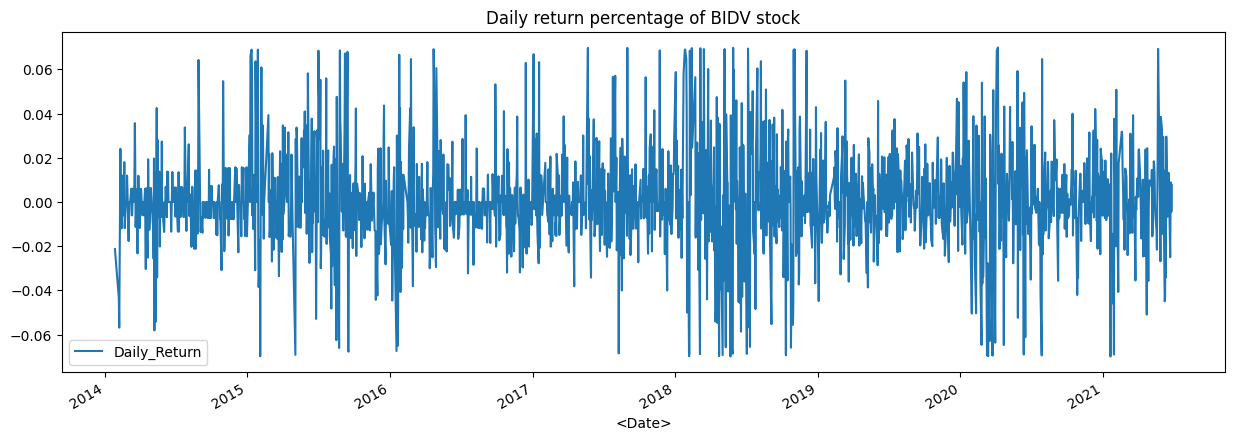

In [148]:
# use pct_change to find the percent change for each day
stock_price_df['Daily_Return'] = stock_price_df['<Close>'].pct_change()
# plot the daily return percentage
stock_price_df.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of BIDV stock')
plt.show()

# LSTM
## Preparing dataset

In [149]:
# normalize data
df1 = stock_price_df.copy(deep=True)

# use standardize the data
scaler = StandardScaler()
df1['<Open>'] = scaler.fit_transform(df1['<Open>'].values.reshape(-1,1))
df1['<High>'] = scaler.fit_transform(df1['<High>'].values.reshape(-1,1))
df1['<Low>'] = scaler.fit_transform(df1['<Low>'].values.reshape(-1,1))
df1['<Close>'] = scaler.fit_transform(df1['<Close>'].values.reshape(-1,1))
df1['<Volume>'] = scaler.fit_transform(df1['<Volume>'].values.reshape(-1,1))

data = df1[['<Open>','<High>','<Low>', '<Close>', '<Volume>']].values
data

array([[-0.9744327 , -0.96089113, -0.99161891, -0.98948224,  4.2389048 ],
       [-0.99392801, -1.00566153, -1.01803429, -1.01549432,  0.87456523],
       [-1.02642874, -1.03764279, -1.05105135, -1.06750992, -0.60822317],
       ...,
       [ 1.63486459,  1.70109374,  1.69213877,  1.67662335,  0.44122407],
       [ 1.67767378,  1.6589688 ,  1.70083662,  1.65949324,  0.13996321],
       [ 1.65198827,  1.66739379,  1.67474306,  1.68947094,  0.43998913]])

In [150]:
seq_len = 11
sequences = []
for index in range(len(data) - seq_len + 1): 
    sequences.append(data[index: index + seq_len])
sequences = np.array(sequences)

In [151]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))
test_set_size = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]

x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]

x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_valid = torch.from_numpy(x_valid).float()
y_valid = torch.from_numpy(y_valid).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

## Train test LSTM

In [152]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\372158831.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\372158831.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\372158831.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_valid = torch.tensor(x_valid).float()
C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\372158831.py:5: UserWarning: To co

In [153]:
from torch import nn
class VanillaLSTM(nn.Module):
    def __init__(self, num_feature):
        super(VanillaLSTM, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)
        
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = VanillaLSTM(5)

In [154]:
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

In [155]:
def train(dataloader):
    epoch_loss = 0
    model.train()  
    
    for batch in dataloader:
        optimizer.zero_grad()          
        x,y = batch
        pred = model(x)
        loss = mse(pred[0],y)        
        loss.backward()               
        optimizer.step()      
        epoch_loss += loss.item()  
        
    return epoch_loss

In [156]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()  
    
    with torch.no_grad():
      for batch in dataloader:   
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)              
          epoch_loss += loss.item()  
        
    return epoch_loss / len(dataloader)

In [157]:
n_epochs = 1000
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, './checkpoint/saved_weights.pt')

    if (epoch % 200 == 0):
        print(f'\tEpoch: {epoch} | ' + f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Epoch: 200 | 	Train Loss: 2.07232 | 	Val Loss: 0.04718

	Epoch: 400 | 	Train Loss: 0.42649 | 	Val Loss: 0.05657

	Epoch: 600 | 	Train Loss: 0.27440 | 	Val Loss: 0.06727

	Epoch: 800 | 	Train Loss: 0.24277 | 	Val Loss: 0.06708

	Epoch: 1000 | 	Train Loss: 0.29905 | 	Val Loss: 0.06952



In [158]:
model=torch.load('./checkpoint/saved_weights.pt')

In [159]:
x_test = torch.tensor(x_test).float()

with torch.no_grad():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

C:\Users\LT MSI\AppData\Local\Temp\ipykernel_17900\2148643726.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test).float()


In [160]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test, y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test, y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']
vanilla_lstm_metric_df = pd.DataFrame([rmse, mse, mae, r2], columns=['<Open>','<High>','<Low>', '<Close>','<Volume>'], index=index)
vanilla_lstm_metric_df

,<Open>,<High>,<Low>,<Close>,<Volume>
RMSE,0.076210,0.071496,0.085564,0.094193,1.047754
MSE,0.005808,0.005112,0.007321,0.008872,1.097788
MAE,0.054409,0.050464,0.065380,0.073280,0.652077
R2 score,0.904959,0.914391,0.876603,0.851862,0.009548


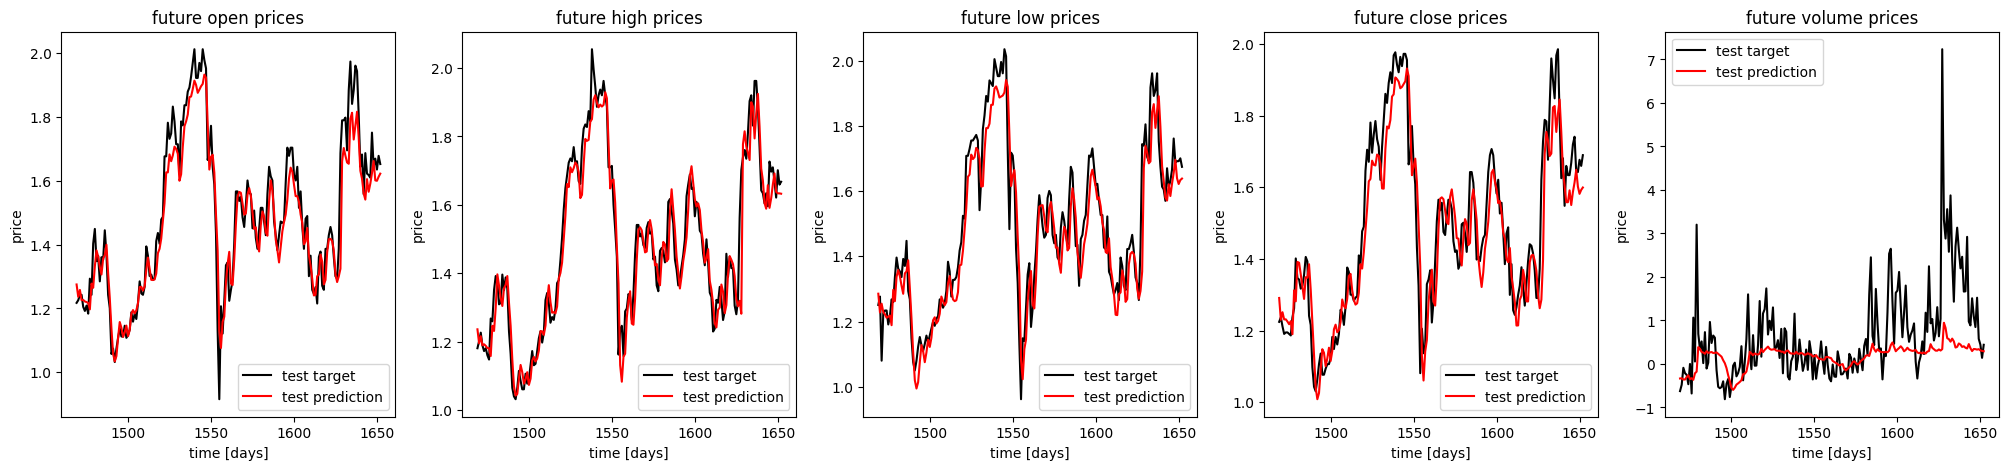

In [161]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figwidth(25)
fig.set_figheight(5)
for i in range(5):
    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,i], color='black', label='test target')

    ax[i].plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,i], color='red', label='test prediction')

    ax[i].set_xlabel('time [days]')
    ax[i].set_ylabel('price')
    ax[i].legend(loc='best')

ax[0].set_title('future open prices')
ax[1].set_title('future high prices')
ax[2].set_title('future low prices')
ax[3].set_title('future close prices')
ax[4].set_title('future volume prices')

plt.show()

In [165]:
# Get the last sequence of historical data as features for predicting the next 10 days
last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions for the next 10 days
PRED_DAYS = 10
with torch.no_grad():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PRED_DAYS, 5).numpy()

# inverse transform the predicted values
pred_days = scaler.inverse_transform(pred_days)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['<Open>', '<High>', '<Low>', '<Close>', '<Volume>']
)

df_pred


array([[4406850. , 4421154.5, 4431809.5, 4386205.5, 2345488.5],
       [4368844. , 4382170. , 4382149.5, 4347675. , 2320715.2],
       [4325884.5, 4337556.5, 4329513. , 4306504. , 2304451.2],
       [4287144.5, 4297260.5, 4281560. , 4269985.5, 2290462.2],
       [4251492.5, 4260017. , 4238940. , 4235878.5, 2279392.8],
       [4218631. , 4225732.5, 4200574.5, 4203690. , 2271425.2],
       [4188352.8, 4192529. , 4164715. , 4175768.8, 2256605.2],
       [4159850.2, 4162190.8, 4133404. , 4148057.8, 2249392. ],
       [4133154.2, 4133920. , 4104734. , 4122011.2, 2244176.8],
       [4108029.8, 4108474.5, 4078624.8, 4096572.2, 2245348.5]],
      dtype=float32)

In [166]:
# RMSE, MSE, MAE, R2 score for next 10 days
y_test_pred = y_test_pred[:PRED_DAYS]
rmse = np.sqrt(mean_squared_error(y_test[:PRED_DAYS], y_test_pred, multioutput='raw_values'))
mse = mean_squared_error(y_test[:PRED_DAYS], y_test_pred, multioutput='raw_values')
mae = mean_absolute_error(y_test[:PRED_DAYS], y_test_pred, multioutput='raw_values')
r2 = r2_score(y_test[:PRED_DAYS], y_test_pred, multioutput='raw_values')
index = ['RMSE','MSE', 'MAE', 'R2 score']
vanilla_lstm_metric_df = pd.DataFrame([rmse, mse, mae, r2], columns=['<Open>','<High>','<Low>', '<Close>','<Volume>'], index=index)
vanilla_lstm_metric_df


,<Open>,<High>,<Low>,<Close>,<Volume>
RMSE,0.041214,0.041749,0.065654,0.041202,0.510652
MSE,0.001699,0.001743,0.004310,0.001698,0.260765
MAE,0.032696,0.027676,0.043858,0.038437,0.351099
R2 score,-0.868952,-0.181056,-0.496909,-1.798194,-0.148819


In [186]:
# Get the last sequence of historical data as features for predicting the next 5 days
last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions for the next 5 days
PRED_DAYS = 5

with torch.no_grad():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]

pred_days = last_sequence.reshape(PRED_DAYS, 6).numpy()

# inverse transform the predicted values

pred_days = scaler.inverse_transform(last_sequence)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['<Open>', '<High>', '<Low>', '<Close>', '<Volume>']
)

df_pred


RuntimeError: shape '[5, 5]' is invalid for input of size 50